In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #visualisation
from geopy.geocoders import Nominatim
%matplotlib inline 
sns.set(color_codes=True)
import datetime
from datetime import date
from scipy import stats

In [2]:
cases_train = pd.read_csv('../data/cases_2021_train.csv')
cases_test = pd.read_csv('../data/cases_2021_test.csv')
location = pd.read_csv('../data/location_2021.csv')

1.1 Cleaning messy outcome labels

In [3]:
cases_train.groupby('outcome').size()

outcome
Alive                               127
Dead                                  9
Death                                 4
Deceased                           3361
Died                                  4
Discharged                            2
Discharged from hospital              3
Hospitalized                     135524
Receiving Treatment                 183
Recovered                         62875
Stable                               24
Under treatment                     243
critical condition                    1
death                                29
died                                624
discharge                           114
discharged                           82
recovered                          2435
recovering at home 03.03.2020         2
released from quarantine              3
stable                              107
stable condition                     90
dtype: int64

In [4]:
cases_train.loc[cases_train.outcome == 'Discharged', 'outcome_group'] = "hospitalized"
cases_train.loc[cases_train.outcome == 'Discharged from hospital', 'outcome_group'] = "hospitalized"
cases_train.loc[cases_train.outcome == 'Hospitalized', 'outcome_group'] = "hospitalized"
cases_train.loc[cases_train.outcome == 'critical condition', 'outcome_group'] = "hospitalized"
cases_train.loc[cases_train.outcome == 'discharge', 'outcome_group'] = "hospitalized"
cases_train.loc[cases_train.outcome == 'discharged', 'outcome_group'] = "hospitalized"

cases_train.loc[cases_train.outcome == 'Alive', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'Receiving Treatment', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'Stable', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'Under treatment', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'recovering at home 03.03.2020', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'released from quarantine', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'stable', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'stable condition', 'outcome_group'] = "nonhospitalized"

cases_train.loc[cases_train.outcome == 'Dead', 'outcome_group'] = "deceased"
cases_train.loc[cases_train.outcome == 'Death', 'outcome_group'] = "deceased"
cases_train.loc[cases_train.outcome == 'Deceased', 'outcome_group'] = "deceased"
cases_train.loc[cases_train.outcome == 'Died', 'outcome_group'] = "deceased"
cases_train.loc[cases_train.outcome == 'death', 'outcome_group'] = "deceased"
cases_train.loc[cases_train.outcome == 'died', 'outcome_group'] = "deceased"

cases_train.loc[cases_train.outcome == 'Recovered', 'outcome_group'] = "recovered"
cases_train.loc[cases_train.outcome == 'recovered', 'outcome_group'] = "recovered"
cases_train = cases_train.drop(columns=['outcome'])

In [5]:
cases_train.groupby('outcome_group').size()

outcome_group
deceased             4031
hospitalized       135726
nonhospitalized       779
recovered           65310
dtype: int64

1.2 Outcome labels
For train dataset, what we are doing in 1.1 is data cleaning. 
For test dataset, using other attribute to predict the outcome_group is classification.

1.3 Exploratory Data Analysis

1.4 Data cleaning and imputing missing values

In [6]:
# Codes that used to check which columns contain NaN
nan_values = cases_train.isna()
nan_columns = nan_values.any()
columns_with_nan = cases_train.columns[nan_columns].tolist()
print(columns_with_nan)

['age', 'sex', 'province', 'country', 'date_confirmation', 'additional_information', 'source']


In [7]:
# Codes that used to check which columns contain NaN
nan_values = cases_test.isna()
nan_columns = nan_values.any()
columns_with_nan = cases_test.columns[nan_columns].tolist()
print(columns_with_nan)

['age', 'sex', 'province', 'country', 'date_confirmation', 'additional_information', 'source', 'outcome_group']


In [8]:
cases_train = cases_train[cases_train['age'].notna()]
cases_test = cases_test[cases_test['age'].notna()]

In [9]:
# Function that handle age column.
def handleAge(age):
    if ' months' in age:
        return round(float(age.replace(' months', ''))/12)
    positionOfTo = age.find('-')
    if positionOfTo >= 1:
        age = age[0:positionOfTo]
    return(round(float(age)))

In [10]:
cases_train['age'] = cases_train['age'].apply(handleAge)
cases_test['age'] = cases_test['age'].apply(handleAge)

In [11]:
# Replace NaN in sex column by 'unknown'
cases_train['sex'] = cases_train['sex'].replace(np.nan, 'unknown')
cases_test['sex'] = cases_test['sex'].replace(np.nan, 'unknown')

In [12]:
# With lait land long, we can use geopy to find the country and provience name.
def handleCountry(lait,long, country):
    if pd.notna(country):
        return country
    else:
        if lait > 90 or lait < -90 or long > 180 or long < -180:
            return country
        geolocator = Nominatim(user_agent="geoapiExercises")
        loc = geolocator.reverse(str(lait)+','+str(long), language='en', timeout=None)
        if loc is None:
            return country
        address = loc.raw['address']
        Country = address.get('country', '')
        return Country
def handleProvince(long, lait, province):
    if pd.notna(province):
        return province
    else:
        if lait > 90 or lait < -90 or long > 180 or long < -180:
            return province
        geolocator = Nominatim(user_agent="geoapiExercises")
        loc = geolocator.reverse(str(lait)+","+str(long), language='en', timeout=None)
        if loc is None:
            return province
        address = loc.raw['address']
        Province = address.get('state', '')
        return Province

To handle GeocoderServiceError:

Download https://letsencrypt.org/certs/lets-encrypt-r3.pem

rename file .pem to .cer

install

In [13]:
try:
    cases_train['country'] = cases_train.apply(lambda row : handleCountry(row['latitude'], row['longitude'], row['country']), axis = 1)
    cases_train['province'] = cases_train.apply(lambda row: handleProvince(row['latitude'], row['longitude'], row['province']), axis = 1)
    cases_test['country'] = cases_test.apply(lambda row : handleCountry(row['latitude'], row['longitude'], row['country']), axis = 1)
    cases_test['province'] = cases_test.apply(lambda row: handleProvince(row['latitude'], row['longitude'], row['province']), axis = 1)
except:
    print("Unable to reach geopy server, just remove rows with NaN in country and provience instead.")


# For rows still have country or province as NaN, replace NaN with 'unknown'
cases_train[['country', 'province']] = cases_train[['country','province']].fillna(value='unknown')
cases_test[['country', 'province']] = cases_test[['country','province']].fillna(value='unknown')


In [14]:
allDate = cases_train['date_confirmation'].dropna().tolist() + cases_test['date_confirmation'].dropna().tolist()

In [15]:
# Use the average date to replace NaN
# May cause dataset skewed
totalDays = 0
initialDay = date(1, 1, 1)
for i in allDate:
    day = int(i[0:2])
    month = int(i[3:5])
    year = int(i[6:10])
    currDate = date(year, month, day)
    totalDays = totalDays + (currDate - initialDay).days
avgDays = round(totalDays/len(allDate))
avgDate = initialDay + datetime.timedelta(days = avgDays)
avgDateInStr = str(avgDate.day) + '.' + str(avgDate.month) + '.' + str(avgDate.year)
cases_train['date_confirmation'] = cases_train['date_confirmation'].fillna(avgDateInStr)
cases_test['date_confirmation'] = cases_test['date_confirmation'].fillna(avgDateInStr)

In [16]:
# Replace NaN in additional_information and source with empty string
cases_train['additional_information'] = cases_train['additional_information'].fillna('')
cases_test['additional_information'] = cases_test['additional_information'].fillna('')
cases_train['source'] = cases_train['source'].fillna('')
cases_test['source'] = cases_test['source'].fillna('')

In [17]:
# Remove rows with NaN in Lat and Long_
location = location[location['Lat'].notna()]
location = location[location['Long_'].notna()]

In [18]:
# Geopy can not really help find the province state with lait and long
# Replace NaN in Province_State with unknown
# location['Province_State'] = location.apply(lambda row: handleProvince(row['Lat'], row['Long_'], row['Province_State']), axis = 1)
location['Province_State'] = location['Province_State'].fillna('Unknown')

In [19]:
# Use average recover ratio to calculate number of recovered and active
# MAY CAUSE DATASET SKEWED
def handleRecovered(Confirmed, Deaths, Recovered, Active, MeanRecoverRatio):
    if pd.notna(Recovered):
        return Recovered
    else:
        if pd.notna(Active):
            return (Confirmed-Deaths)-Active
        else:
            return (Confirmed-Deaths)*MeanRecoverRatio
        return Country
def handleActive(Confirmed, Deaths, Recovered, Active, MeanRecoverRatio):
    if pd.notna(Active):
        return Active
    else:
        if pd.notna(Recovered):
            return (Confirmed-Deaths)-Recovered
        else:
            return (Confirmed-Deaths)*(1-MeanRecoverRatio)
        return Country

In [20]:
recoveredAndActive = location.get(['Recovered','Active'])
recoveredAndActive = recoveredAndActive[recoveredAndActive['Recovered'].notna()]
recoveredAndActive = recoveredAndActive[recoveredAndActive['Active'].notna()]
recoveredAndActive['RecoverRatio'] = recoveredAndActive['Recovered']/(recoveredAndActive['Recovered']+recoveredAndActive['Active'])
MeanRecoverRatio = recoveredAndActive['RecoverRatio'].mean()


location['Recovered'] = location.apply(lambda row: handleRecovered(row['Confirmed'], row['Deaths'], row['Recovered'], row['Active'],MeanRecoverRatio), axis = 1)
location['Active'] = location.apply(lambda row: handleActive(row['Confirmed'], row['Deaths'], row['Recovered'], row['Active'],MeanRecoverRatio), axis = 1)

location['Case_Fatality_Ratio'] = location['Case_Fatality_Ratio'].fillna(0)
location['Incident_Rate'] = location['Incident_Rate'].fillna(0)

In [21]:
nan_values = location.isna()
nan_columns = nan_values.any()
columns_with_nan = location.columns[nan_columns].tolist()
print(columns_with_nan)

[]


1.5 Dealing with outliers
In previous steps, we have dropped rows in cases_train, cases_test and location with wrong latitude and longitude. Thus, we do not have to handle outlaiers in latitude and longitude. 
Moreover, by checking the box plot of age, we can say that the age values are reasonable. Age in train and test sets does not include particularly unreasonable values.

However, by checking the box plots, we can see there are significent outliers in 'Confirmed', 'Recovered', 'Active'

In [22]:
cases_train.select_dtypes(include=np.number)

,age,latitude,longitude
5,40,13.08362,80.28252
43,37,12.68224,79.98008
46,40,8.96350,77.30821
48,27,13.08362,80.28252
52,54,10.38486,78.79294
...,...,...,...
205787,17,13.08362,80.28252
205789,25,25.73271,86.98845
205792,16,13.08362,80.28252
205810,52,12.68224,79.98008


In [23]:
cases_test.select_dtypes(include=np.number)

,age,latitude,longitude,outcome_group
3,23,12.52735,76.89465,NaN
13,18,25.23169,83.92138,NaN
14,26,17.33274,76.84035,NaN
16,21,13.08362,80.28252,NaN
18,32,13.08362,80.28252,NaN
...,...,...,...,...
101362,32,13.99363,74.55087,NaN
101366,33,13.08362,80.28252,NaN
101373,45,13.08362,80.28252,NaN
101377,18,26.49002,84.89589,NaN


In [24]:
location.select_dtypes(include=np.number)

,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio
0,33.93911,67.709953,56454,2484,51550.0,2420.0,145.020308,4.400043
1,41.15330,20.168300,125157,2235,91271.0,31651.0,4349.051359,1.785757
2,28.03390,1.659600,117192,3093,81538.0,32561.0,267.250200,2.639259
3,42.50630,1.521800,12010,115,11315.0,580.0,15543.907332,0.957535
4,-11.20270,17.873900,22311,537,20493.0,1281.0,67.884191,2.406884
...,...,...,...,...,...,...,...,...
3998,5.31170,103.132400,3595,13,3547.0,35.0,287.576994,0.361613
3999,3.13900,101.686900,37819,118,36631.0,1070.0,2126.574449,0.312012
4000,5.28310,115.230800,2327,12,2282.0,33.0,2341.046278,0.515685
4001,2.92640,101.696400,1142,8,1102.0,32.0,1083.491461,0.700525


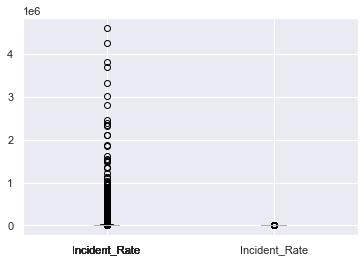

In [25]:
boxplot1 = cases_train.boxplot(column=['age'])
boxplot2 = cases_test.boxplot(column=['age'])
boxplot3 = location.boxplot(column=['Lat', 'Long_'])
boxplot4 = location.boxplot(column=['Confirmed'])
boxplot5 = location.boxplot(column=[ 'Deaths'])
boxplot6 = location.boxplot(column=[ 'Recovered'])
boxplot7 = location.boxplot(column=['Active'])
boxplot8 = location.boxplot(column=[ 'Incident_Rate'])


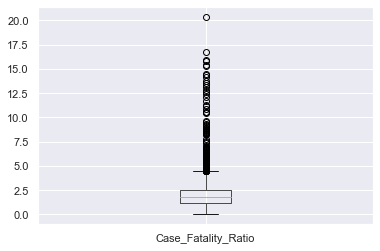

In [26]:
boxplot9 = location.boxplot(column=[ 'Case_Fatality_Ratio'])

In [27]:
outlierColumns = location[['Case_Fatality_Ratio']]

In [28]:
filteredLocation = outlierColumns[(np.abs(stats.zscore(outlierColumns)) < 2).all(axis=1)]
# Reference: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe

In [29]:
location = pd.concat([location, filteredLocation], axis=1, join="inner")
location = location.loc[:,~location.columns.duplicated()]

1.6 Joining the cases and location dataset

In [31]:
location['Country_Region'] = location['Country_Region'].replace(['US'],'United States')
location['Country_Region'] = location['Country_Region'].replace(['Korea, South'],'South Korea')
location['Country_Region'] = location['Country_Region'].replace(['Taiwan*'],'Taiwan')

In [32]:
aggColumnsInLocation = location[['Province_State', 'Country_Region', 'Confirmed', 'Deaths', 'Recovered', 'Active']]
meanColumnsInLocation = location[['Province_State', 'Country_Region', 'Incident_Rate', 'Case_Fatality_Ratio']]

In [33]:
aggColumnsInLocation = aggColumnsInLocation.groupby(['Province_State', 'Country_Region']).sum()


In [34]:
meanColumnsInLocation = meanColumnsInLocation.groupby(['Province_State', 'Country_Region']).mean()


In [35]:
groupedLocation = pd.merge(aggColumnsInLocation, meanColumnsInLocation, on=['Province_State', 'Country_Region'], how='inner')
groupedLocation

,,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio
Province_State,Country_Region,,,,,,
Abruzzo,Italy,65237,2136,52969.0,10132.0,4973.924580,3.274216
Acre,Brazil,69657,1262,54045.0,14350.0,7898.201115,1.811735
Adygea Republic,Russia,14101,163,13365.0,573.0,3110.221979,1.155946
Aichi,Japan,27394,583,25985.0,826.0,362.726868,2.128203
Akita,Japan,283,6,271.0,6.0,29.281213,2.120141
...,...,...,...,...,...,...,...
Zaporizhia Oblast,Ukraine,78386,1415,69207.0,7764.0,4595.166241,1.805169
Zeeland,Netherlands,20788,222,0.0,20566.0,5420.769359,1.067924
Zhejiang,China,1323,1,1320.0,2.0,2.049016,0.075586


In [36]:
joined_case_train = pd.merge(cases_train, groupedLocation,  how='left', left_on=['country','province'], right_on = ['Country_Region','Province_State'])
joined_case_test = pd.merge(cases_test, groupedLocation,  how='left', left_on=['country','province'], right_on = ['Country_Region','Province_State'])

In [37]:
joined_case_train

,age,sex,province,country,latitude,longitude,date_confirmation,additional_information,source,chronic_disease_binary,outcome_group,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio
0,40,female,Tamil Nadu,India,13.08362,80.28252,17.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
1,37,unknown,Tamil Nadu,India,12.68224,79.98008,04.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
2,40,unknown,Tamil Nadu,India,8.96350,77.30821,04.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
3,27,male,Tamil Nadu,India,13.08362,80.28252,13.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
4,54,male,Tamil Nadu,India,10.38486,78.79294,27.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23048,17,female,Tamil Nadu,India,13.08362,80.28252,20.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
23049,25,male,Bihar,India,25.73271,86.98845,30.05.2020,,https://twitter.com/BiharHealthDept/status/126...,False,hospitalized,265527.0,1576.0,262371.0,1580.0,212.762145,0.593537
23050,16,female,Tamil Nadu,India,13.08362,80.28252,18.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
23051,52,male,Tamil Nadu,India,12.68224,79.98008,13.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463


In [38]:
joined_case_test

,age,sex,province,country,latitude,longitude,date_confirmation,additional_information,source,chronic_disease_binary,outcome_group,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio
0,23,female,Karnataka,India,12.52735,76.89465,23.05.2020,Returnees for Maharashtra,https://twitter.com/DHFWKA/status/126411013913...,False,NaN,997004.0,12567.0,956170.0,28267.0,1475.672533,1.260476
1,18,male,Bihar,India,25.23169,83.92138,21.05.2020,,https://twitter.com/BiharHealthDept/status/126...,False,NaN,265527.0,1576.0,262371.0,1580.0,212.762145,0.593537
2,26,male,Karnataka,India,17.33274,76.84035,27.05.2020,Travelled from Maharastra,https://twitter.com/DHFWKA/status/126554867154...,False,NaN,997004.0,12567.0,956170.0,28267.0,1475.672533,1.260476
3,21,male,Tamil Nadu,India,13.08362,80.28252,19.03.2020,"Returned from Dublin, Ireland on 17/3",https://twitter.com/vijayabaskarofl/status/124...,False,NaN,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
4,32,female,Tamil Nadu,India,13.08362,80.28252,13.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,NaN,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11369,32,female,Karnataka,India,13.99363,74.55087,09.05.2020,Contact of KA-P750,https://twitter.com/DHFWKA/status/125909662006...,False,NaN,997004.0,12567.0,956170.0,28267.0,1475.672533,1.260476
11370,33,female,Tamil Nadu,India,13.08362,80.28252,15.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,NaN,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
11371,45,female,Tamil Nadu,India,13.08362,80.28252,08.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,NaN,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
11372,18,male,Bihar,India,26.49002,84.89589,21.05.2020,,https://twitter.com/PIB_Patna/status/126350453...,False,NaN,265527.0,1576.0,262371.0,1580.0,212.762145,0.593537
